In [1]:
from openbb import obb
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np

plt.rcParams["figure.figsize"] = (15,7)
plt.style.use("dark_background")
pd.set_option('display.max_columns', None)

from dotenv import dotenv_values

config = dotenv_values(".env") 
obb.account.login(pat=config['OPENBB_PAT'])

import libs.utils

In [2]:
start_date = '2009-08-01'
end_date = '2020-01-01'

In [3]:
TQQQ_OBB = obb.equity.price.historical('TQQQ', provider='yfinance', start_date=start_date, end_date=end_date)
TQQQ = TQQQ_OBB.to_dataframe()
TQQQ.index = pd.to_datetime(TQQQ.index)
TQQQ.head()

,open,high,low,close,volume,split_ratio,dividend,capital_gains
date,,,,,,,,
2010-02-11,0.406875,0.434896,0.405573,0.432552,3456000,0.0,0.0,0.0
2010-02-12,0.420781,0.438073,0.418333,0.434323,8601600,0.0,0.0,0.0
2010-02-16,0.444531,0.452188,0.437552,0.451146,9619200,0.0,0.0,0.0
2010-02-17,0.457188,0.458906,0.450313,0.458802,19180800,0.0,0.0,0.0
2010-02-18,0.458333,0.470260,0.455573,0.467500,38860800,0.0,0.0,0.0


In [4]:
TQQQ['vwma_10'] = ta.vwma(close=TQQQ.close, volume=TQQQ.volume, length=10)
TQQQ['vwma_20'] = ta.vwma(close=TQQQ.close, volume=TQQQ.volume, length=20)
TQQQ['sma_10'] = ta.sma(close=TQQQ.close, length=10)
TQQQ['rsi_14'] = ta.rsi(close=TQQQ.close, length=14)

TQQQ.dropna(inplace=True)

In [5]:
TQQQ.head()

,open,high,low,close,volume,split_ratio,dividend,capital_gains,vwma_10,vwma_20,sma_10,rsi_14
date,,,,,,,,,,,,
2010-03-11,0.539635,0.548698,0.536042,0.547917,26956800,0.0,0.0,0.0,0.507691,0.479648,0.508412,87.243091
2010-03-12,0.553958,0.553958,0.542865,0.549167,18067200,0.0,0.0,0.0,0.518015,0.482540,0.516823,87.387888
2010-03-15,0.545521,0.549219,0.533854,0.545469,21196800,0.0,0.0,0.0,0.523313,0.486014,0.522870,84.337955
2010-03-16,0.550833,0.557344,0.545104,0.555781,23289600,0.0,0.0,0.0,0.531477,0.489807,0.529656,85.823763
2010-03-17,0.557344,0.567552,0.555000,0.559635,19910400,0.0,0.0,0.0,0.539436,0.493641,0.536557,86.345139


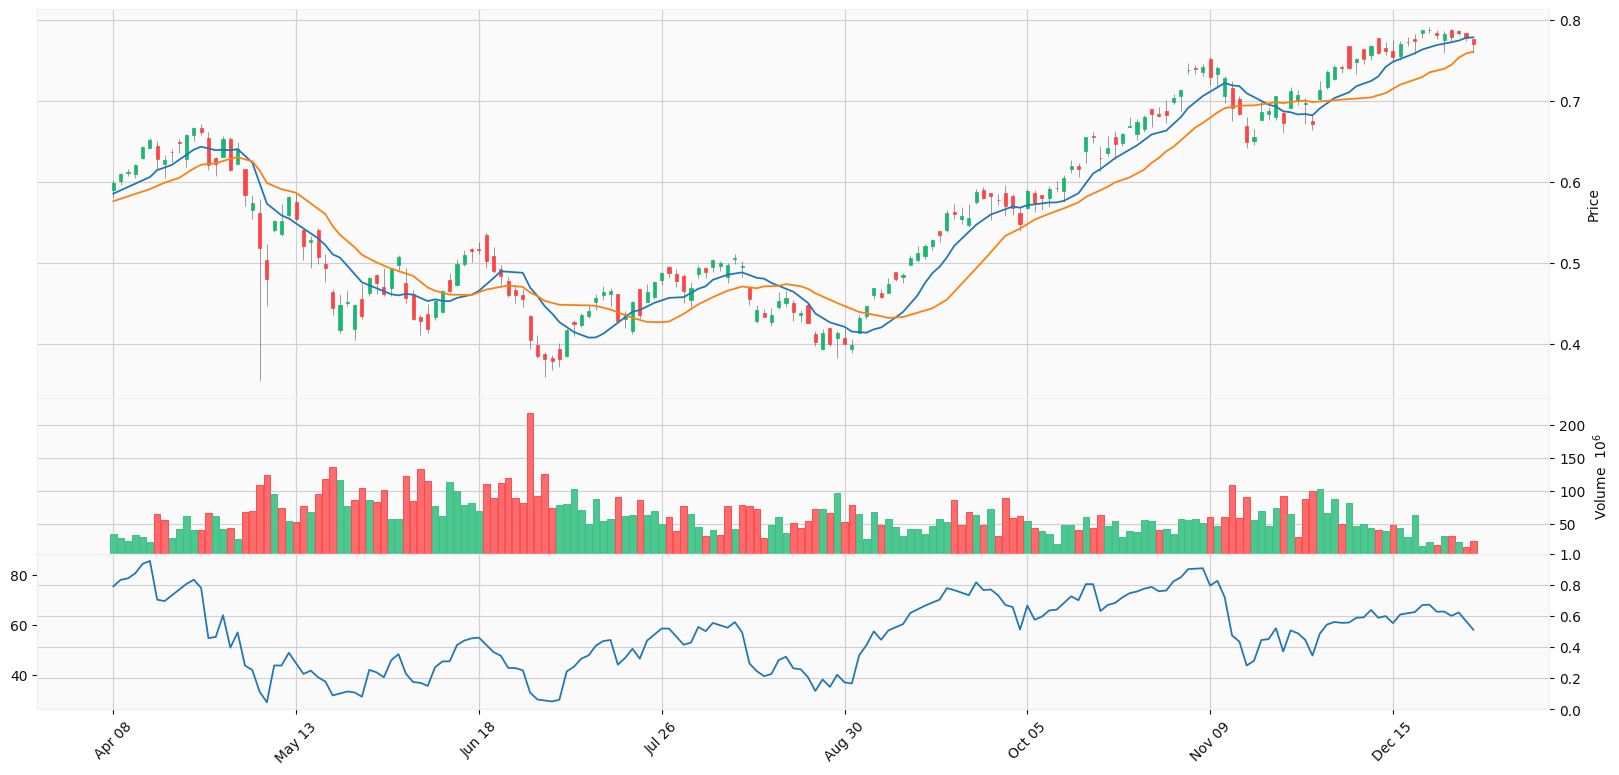

In [6]:
libs.utils.plot_graph(TQQQ, start='2010-04-08', end='2011-01-01', selected_cols_regex=['vwma'], panel_cols_regex=['rsi'])